In [1]:
import pickle
import pandas as pd
import torch
import numpy as np

from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
F_DOMAIN = 'examples/hospital_pre_domain.pkl'
F_RAW = 'testdata/hospital.csv'
F_CLEAN = 'testdata/hospital_clean.csv'
F_DK = 'examples/hospital_dk_cells.pkl'

In [3]:
df_dom = pd.read_pickle(F_DOMAIN)
df_raw = pd.read_csv(F_RAW)
df_clean = pd.read_csv(F_CLEAN)
df_dk = pd.read_pickle(F_DK)

## Reference DF

In [21]:
df_ref = df_dom[['_tid_', 'attribute', 'init_value']].merge(df_clean[['tid', 'attribute', 'correct_val']],
                                                   left_on=['_tid_', 'attribute'], right_on=['tid', 'attribute'])
df_ref.drop('tid', axis='columns', inplace=True)
df_ref = df_ref.merge(df_dk, on=['_tid_', 'attribute'], how='left')
df_ref['_cid_'] = ~df_ref['_cid_'].isnull()
df_ref.rename({'_cid_': 'is_dk'}, axis='columns', inplace=True)

df_ref = df_ref.merge(df_dom[['_tid_', 'attribute', 'domain']], on=['_tid_', 'attribute'])

In [22]:
df_ref.head()

,_tid_,attribute,init_value,correct_val,is_dk,domain
0,0,Address1,1720 university blvd,1720 university blvd,True,1300 south montgomery avenue|||1720 university...
1,0,City,birmingham,birmingham,True,birmingham|||birminghxm|||birmingxam|||birminx...
2,0,Condition,surgical infection prevention,surgical infection prevention,True,surgical infection prevention|||surgical ixfec...
3,0,CountyName,jefferson,jefferson,True,jefferson|||jeffersxn|||jexxerson|||jxffxrson
4,0,EmergencyService,yes,yes,True,no|||xes|||xo|||yes|||yex|||yxs


In [47]:
df_ref.loc[df_ref.correct_val == '1720 university blvd', 'init_value'].unique()

array(['1720 university blvd', '1720 univxrsity blvd'], dtype=object)

## Model stuff

In [126]:
idxs = pickle.load(open('examples/tuple_embed_200_epochs_attr_bias_shuf_2_idxs.pkl', 'rb'))

In [127]:
attr_idx = pickle.load(open('examples/tuple_embed_200_epochs_attr_bias_shuf_2_attr_idx.pkl', 'rb'))

In [199]:
sdict = torch.load('examples/tuple_embed_50_epochs_0.001_attrW_sdict.pkl')

In [200]:
inW_full = sdict['in_W'].numpy()
outW_full = sdict['out_W'].numpy()
outB_full = sdict['out_B'].numpy()
attrW_full = sdict['attr_W'].numpy()

In [129]:
tsne = TSNE(metric='cosine')

In [130]:
inW_vecs = tsne.fit_transform(inW_full)
outW_vecs = tsne.fit_transform(outW_full)

In [201]:
# Returns softmax weight used in weighted average of init values for a given attr
def coattr_weights(attr):
    attr_names = [t[0] for t in filter(lambda t: t[0] != attr, sorted(list(attr_idx.items()), key=lambda t: t[1]))]
    probs = np.exp(attrW_full[attr_idx[attr]]) / np.sum(np.exp(attrW_full[attr_idx[attr]]))
    ret_df =  pd.DataFrame(list(zip(attr_names, probs)), columns=['givenattr/coattr', 'weight'])
    ret_df['weight'] = ret_df['weight'].apply(lambda w: round(w,3))
    ret_df.insert(0, 'attr', attr)
    return ret_df

In [202]:
df_all_attrs = pd.concat([coattr_weights(attr) for attr in attr_idx.keys()], axis=0)

In [203]:
df_all_attrs.pivot(index='attr', columns='givenattr/coattr')

weight                                               \
givenattr/coattr Address1   City Condition CountyName EmergencyService   
attr                                                                     
Address1              NaN  0.000     0.000      0.000            0.000   
City                0.017    NaN     0.000      0.000            0.000   
Condition           0.000  0.000       NaN      0.000            0.000   
CountyName          0.997  0.000     0.000        NaN            0.000   
EmergencyService    0.009  0.008     0.002      0.524              NaN   
HospitalName        0.000  0.000     0.000      0.000            0.000   
HospitalOwner       0.002  0.554     0.000      0.001            0.000   
HospitalType        0.003  0.002     0.047      0.003            0.063   
MeasureCode         0.000  0.000     0.000      0.000            0.000   
MeasureName         0.000  0.000     0.000      0.000            0.000   
PhoneNumber         0.000  0.000     0.000      0.000            0.000   
ProviderNumber      0.000  0.000     0.000      0.000            0.000   
Sample              0.000  0.000     0.999      0.000            0.000   
Score               0.012  0.000     0.001      0.005            0.001   
State               0.046  0.039     0.007      0.023            0.042   
Stateavg            0.000  0.000     0.000      0.000            0.000   
ZipCode             0.000  0.000     0.000      0.000            0.000   

                                                                      \
givenattr/coattr HospitalName HospitalOwner HospitalType MeasureCode   
attr                                                                   
Address1                0.772         0.000        0.000       0.000   
City                    0.004         0.000        0.000       0.000   
Condition               0.000         0.000        0.000       0.004   
CountyName              0.000         0.000        0.000       0.000   
EmergencyService        0.012         0.009        0.008       0.003   
HospitalName              NaN         0.000        0.000       0.000   
HospitalOwner           0.234           NaN        0.000       0.000   
HospitalType            0.006         0.107          NaN       0.011   
MeasureCode             0.000         0.000        0.000         NaN   
MeasureName             0.000         0.000        0.000       1.000   
PhoneNumber             0.498         0.000        0.000       0.000   
ProviderNumber          0.986         0.000        0.000       0.000   
Sample                  0.000         0.000        0.000       0.000   
Score                   0.004         0.010        0.001       0.000   
State                   0.040         0.125        0.045       0.012   
Stateavg                0.000         0.000        0.000       0.996   
ZipCode                 0.455         0.000        0.000       0.000   

                                                                              \
givenattr/coattr MeasureName PhoneNumber ProviderNumber Sample  Score  State   
attr                                                                           
Address1               0.000       0.010          0.216  0.000  0.000  0.000   
City                   0.000       0.965          0.014  0.000  0.000  0.000   
Condition              0.006       0.000          0.000  0.000  0.000  0.000   
CountyName             0.000       0.001          0.001  0.000  0.000  0.000   
EmergencyService       0.004       0.009          0.021  0.369  0.006  0.012   
HospitalName           0.000       0.007          0.992  0.000  0.000  0.000   
HospitalOwner          0.000       0.004          0.181  0.000  0.000  0.000   
HospitalType           0.041       0.007          0.004  0.363  0.230  0.106   
MeasureCode            1.000       0.000          0.000  0.000  0.000  0.000   
MeasureName              NaN       0.000          0.000  0.000  0.000  0.000   
PhoneNumber            0.000         NaN          0.501  

In [156]:
coattr_weights('Stateavg')

[('MeasureCode', 10.088591),
 ('MeasureName', -3.170554),
 ('HospitalName', -4.9121017),
 ('City', -5.2202067),
 ('Score', -5.5690928),
 ('Condition', -5.608377),
 ('ZipCode', -5.672447),
 ('HospitalOwner', -5.764976),
 ('PhoneNumber', -5.8614078),
 ('ProviderNumber', -5.9572453),
 ('Address1', -6.004306),
 ('Sample', -6.0659842),
 ('State', -6.619304),
 ('EmergencyService', -6.640423),
 ('HospitalType', -6.739587),
 ('CountyName', -6.7720594)]

In [158]:
coattr_weights('City')

[('ProviderNumber', 9.501042),
 ('PhoneNumber', 0.032634113),
 ('HospitalName', -2.6035607),
 ('Address1', -4.1896234),
 ('ZipCode', -6.131066),
 ('CountyName', -6.847043),
 ('Condition', -7.426272),
 ('Sample', -7.5231104),
 ('HospitalType', -7.703708),
 ('Stateavg', -7.767697),
 ('HospitalOwner', -7.7716103),
 ('Score', -7.808946),
 ('MeasureCode', -7.840413),
 ('State', -7.857469),
 ('MeasureName', -7.8735957),
 ('EmergencyService', -7.9328065)]

In [159]:
coattr_weights('ZipCode')

[('PhoneNumber', 8.891923),
 ('HospitalName', 1.7498357),
 ('ProviderNumber', -4.543076),
 ('Address1', -5.8246446),
 ('City', -7.1326337),
 ('MeasureCode', -7.887107),
 ('CountyName', -8.083904),
 ('HospitalOwner', -8.099084),
 ('Sample', -8.139692),
 ('EmergencyService', -8.195633),
 ('Stateavg', -8.214812),
 ('HospitalType', -8.22404),
 ('Condition', -8.280035),
 ('MeasureName', -8.31301),
 ('Score', -8.392249),
 ('State', -8.432579)]

In [161]:
coattr_weights('PhoneNumber')

[('HospitalName', 13.010781),
 ('ProviderNumber', -2.7405562),
 ('ZipCode', -3.5124369),
 ('Address1', -3.6840618),
 ('City', -5.024118),
 ('MeasureCode', -5.9357715),
 ('Condition', -6.0148854),
 ('CountyName', -6.0337353),
 ('HospitalOwner', -6.056288),
 ('Stateavg', -6.148366),
 ('HospitalType', -6.1930723),
 ('Sample', -6.330719),
 ('MeasureName', -6.330736),
 ('EmergencyService', -6.4033566),
 ('State', -6.527607),
 ('Score', -6.56773)]

## Plot a row's input and output

In [89]:
from IPython.display import display

In [ ]:
df_ref.insert()

In [121]:
def plot_tid(tid, targ_attr):
    attrs = sorted(df_ref.attribute.unique())
    
    df_tid = df_ref[df_ref['_tid_'] == tid]
    targ_cell = df_tid[df_tid.attribute == targ_attr].iloc[0]
    cor_val = targ_cell['correct_val']
    
    
    
    plt.figure(figsize=(20,10))
    
    dotprods = []
    
    # Plot init points
    for cell in df_tid.to_records():
        if cell['attribute'] == targ_attr:
            dotprods.append(0)
            continue
        dotprods.append(np.dot(inW_full[idxs[cell['attribute']][cell['init_value']]], 
               inW_full[idxs[targ_attr][cor_val]]))
            
        x, y = inW_vecs[idxs[cell['attribute']][cell['init_value']]]
        plt.plot(x, y, 'yo')
        plt.text(x * (1 + 0.01), y * (1 + 0.01) , cell['init_value'][:20], fontsize=20)
        
    df_tid.insert(len(df_tid.columns), 'dot_prod', dotprods)
    
    display(df_tid.sort_values('dot_prod'))
    
    dom_vals = targ_cell['domain'].split('|||')
    # Plot domain
    for dom_val in dom_vals:
        x, y = outW_vecs[idxs[targ_attr][dom_val]]
        if dom_val == cor_val:
            plt.plot(x, y, 'go')
        else:
            plt.plot(x, y, 'ro')
        plt.text(x * (1 + 0.01), y * (1 + 0.01) , dom_val[:20], fontsize=20)
        
        
    plt.figure(figsize=(20,6))
    # Biases of each domain value
    b_vals = [outB_full[idxs[targ_attr][dom_val]][0] for dom_val in dom_vals]
    ticks = list(range(len(b_vals)))
    plt.bar(ticks, b_vals, align='center')
    plt.xticks(ticks, [val[:20] for val in dom_vals])

,_tid_,attribute,init_value,correct_val,is_dk,domain,dot_prod
1654,98,State,xl,al,True,ak|||al|||ax|||xl,-1.001464
1644,98,EmergencyService,no,no,False,no|||xes|||xo|||yes|||yex|||yxs,-0.775044
1642,98,Condition,heart attack,heart attack,True,children s asthma care|||heart attack|||heart ...,-0.328763
1643,98,CountyName,covington,covington,False,blount|||butler|||chambers|||cherokee|||chilto...,-0.314675
1649,98,MeasureName,heart attack patients given beta blocker at di...,heart attack patients given beta blocker at di...,True,heart attack patients given ace inhibitor or a...,-0.250365
1655,98,Stateavg,al_ami-5,al_ami-5,True,al_ami-2|||al_ami-3|||al_ami-4|||al_ami-5|||al...,-0.212381
1648,98,MeasureCode,ami-5,ami-5,True,ami-2|||ami-3|||ami-4|||ami-5|||ami-7a|||ami-x...,-0.067936
1647,98,HospitalType,acute care hosxitals,acute care hospitals,True,acute care hospitals|||acute care hospitaxs|||...,0.000000
1646,98,HospitalOwner,voluntary non-profit - private,voluntary non-profit - private,True,government - federal|||government - hospital d...,0.162599
1653,98,Score,100%,100%,False,0%|||100%|||50%,0.207292


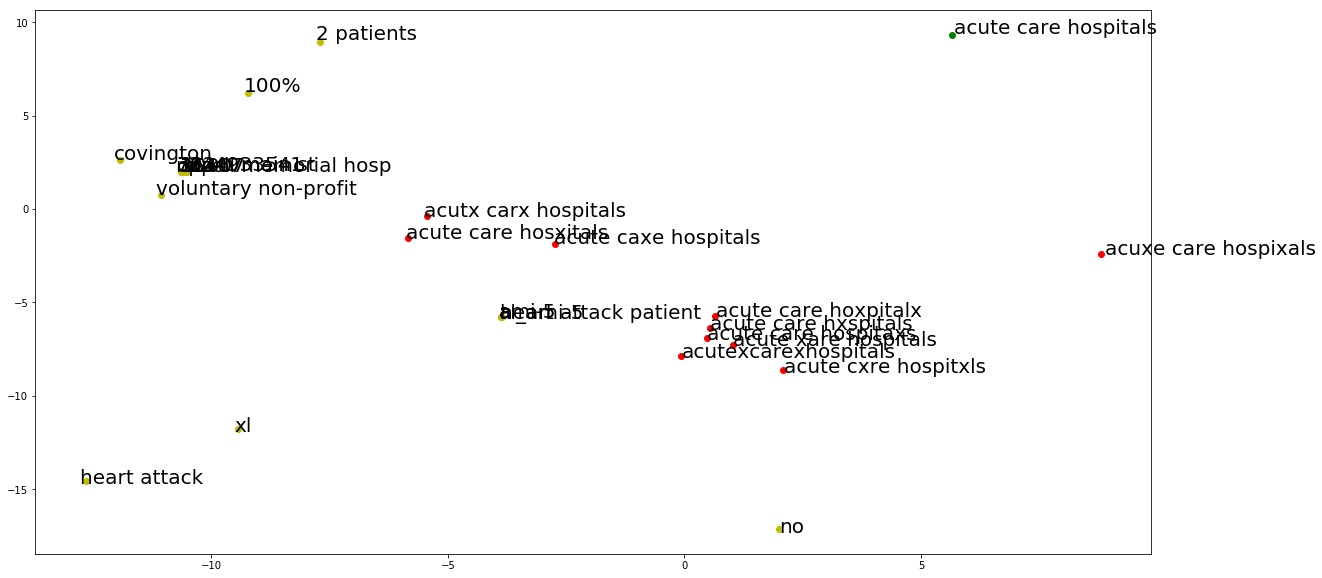

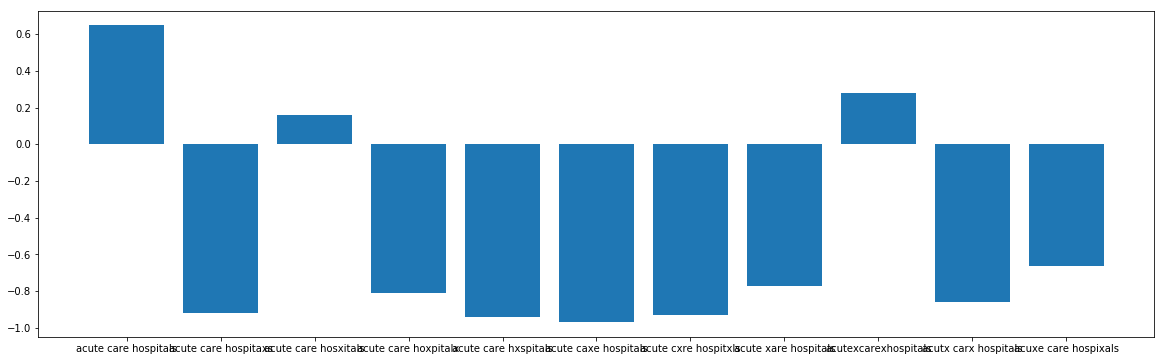

In [122]:
plot_tid(98, 'HospitalType')

,_tid_,attribute,init_value,correct_val,is_dk,domain,dot_prod
6486,386,State,xl,al,True,ak|||al|||ax|||xl,-0.912376
6476,386,EmergencyService,yes,yes,True,no|||xes|||xo|||yes|||yex|||yxs,-0.519907
6485,386,Score,83%,83%,False,100%|||83%|||85%|||94%|||99%,-0.332369
6479,386,HospitalType,acute care hospitals,acute care hospitals,False,acute care hospitals|||acute care hospitaxs|||...,-0.096166
6474,386,Condition,hxart failurx,heart failure,True,heart attack|||heart failure|||hexrt fxilure||...,-0.016707
6482,386,PhoneNumber,25x47x7xx0,2514717110,True,2054877736|||2514717110|||25x47x7xx0|||3342938...,0.000000
6481,386,MeasureName,heart failure patients given discharge instruc...,heart failure patients given discharge instruc...,True,all heart surgery patients whose blood sugar (...,0.629069
6480,386,MeasureCode,hf-1,hf-1,True,hf-1|||hf-3|||hfx1|||hx-1|||pn-5c|||scip-inf-4...,0.655357
6484,386,Sample,146 patients,146 patients,False,146 patients|||18 patients|||227 patients|||24...,0.705198
6487,386,Stateavg,al_hf-1,al_hf-1,True,ak_hf-1|||ak_scip-inf-4|||al_hf-1|||al_hf-3|||...,0.811057


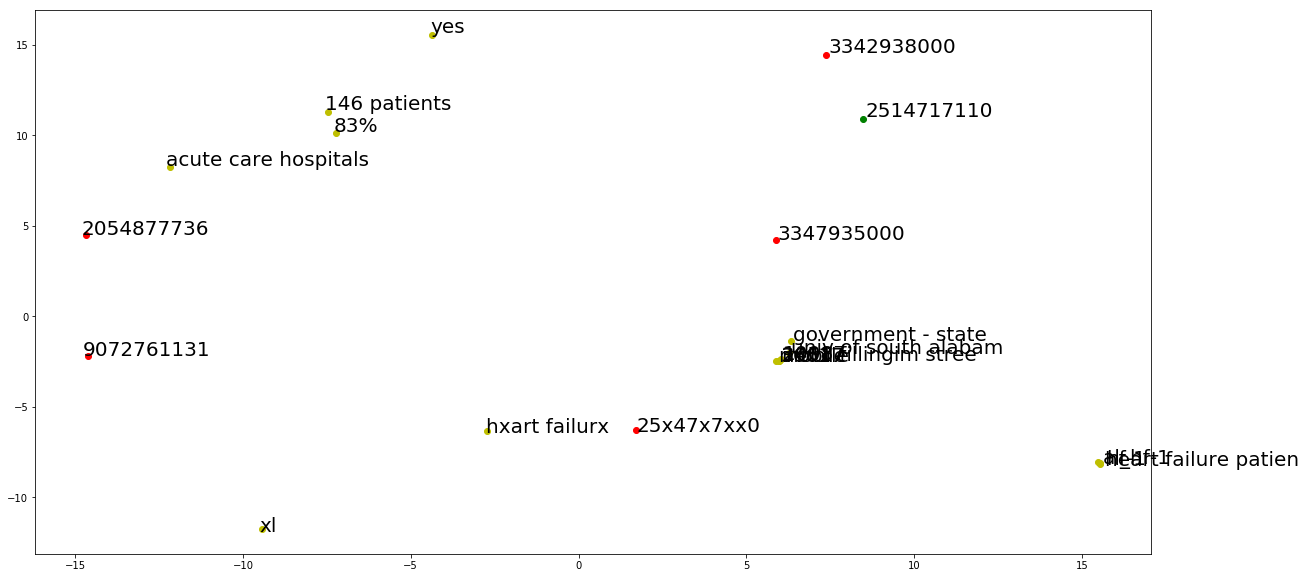

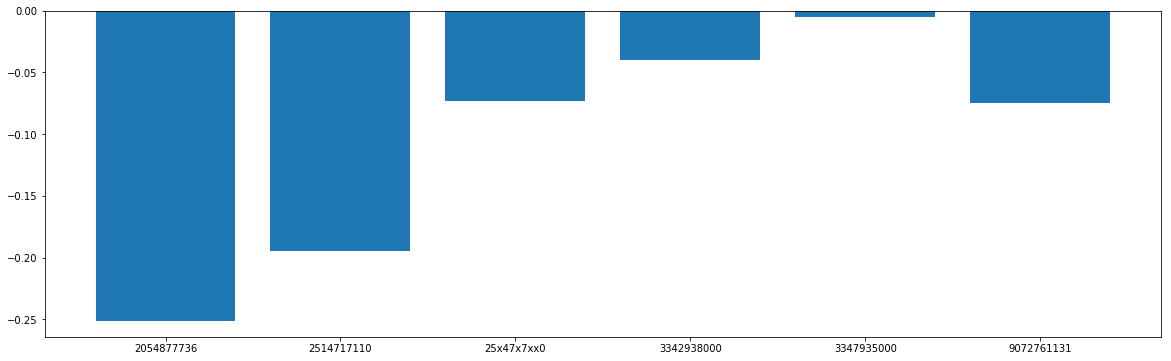

In [123]:
plot_tid(386, 'PhoneNumber')

,_tid_,attribute,init_value,correct_val,is_dk,domain,dot_prod
533,32,MeasureCode,pn-4,pn-4,True,pn-4|||px-4|||scip-card-2,-1.588259
527,32,Condition,pneumonia,pneumonia,True,heart attack|||heart failure|||pneumonia|||sur...,-1.543485
537,32,Sample,107 patients,107 patients,False,107 patients|||268 patients|||42 patients|||49...,-1.213304
534,32,MeasureName,pneumonia patients given smoking cessation adv...,pneumonia patients given smoking cessation adv...,True,pneumonia patients given smoking cessation adv...,-0.870387
540,32,Stateavg,al_pn-4,al_pn-4,True,ak_pn-4|||al_pn-4|||al_scip-card-2,-0.583908
529,32,EmergencyService,yes,yes,True,no|||xes|||xo|||yes|||yex|||yxs,-0.503644
538,32,Score,99%,99%,False,95%|||96%|||99%,0.000000
539,32,State,al,al,False,ak|||al|||ax|||xl,0.108283
532,32,HospitalType,acute care hospitals,acute care hospitals,True,acute care hospitals|||acute care hospitaxs|||...,0.164074
531,32,HospitalOwner,government - hospital district or authority,government - hospital district or authority,True,government - hospital district or authority|||...,0.401657


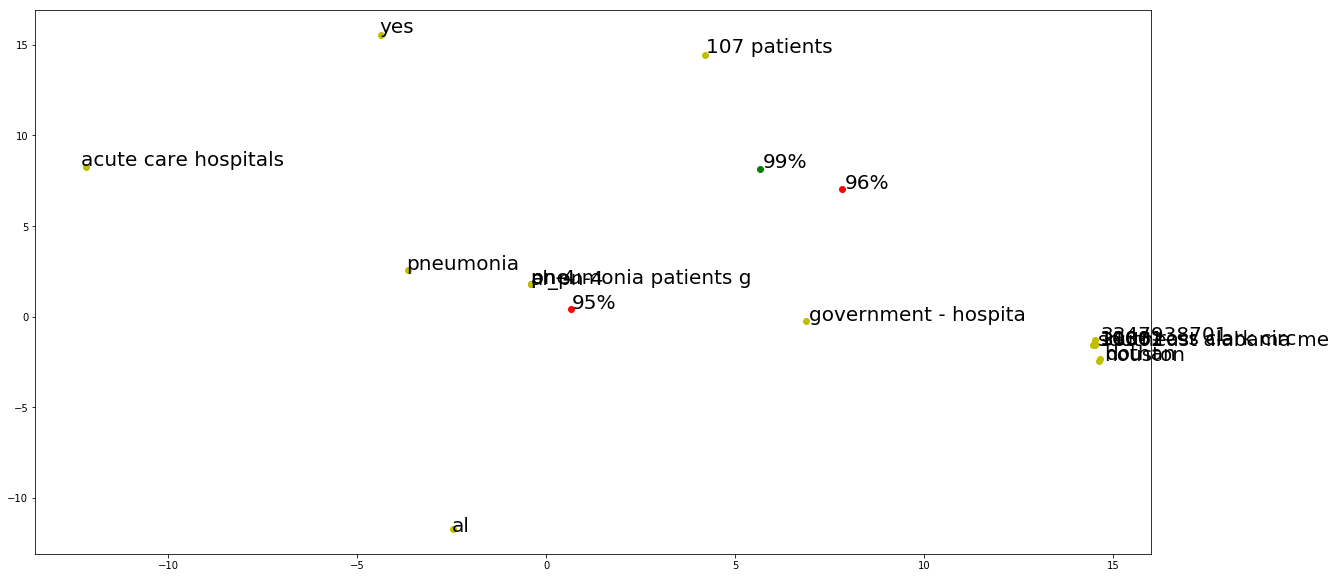

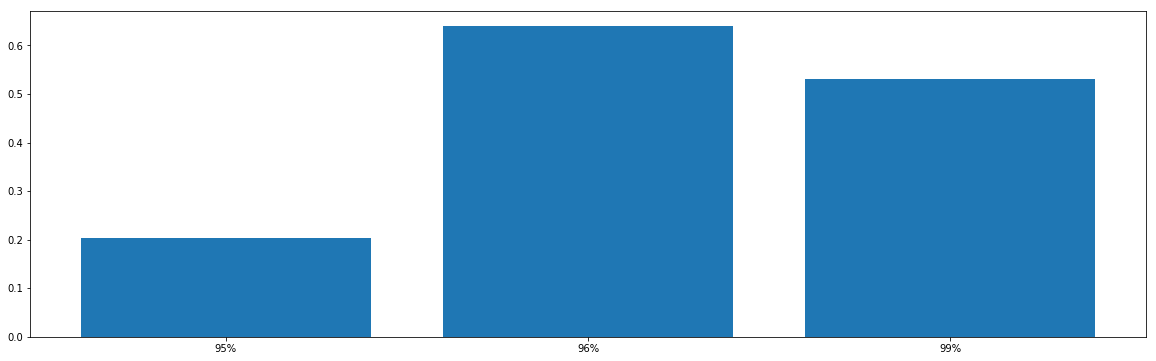

In [124]:
plot_tid(32, 'Score')

,_tid_,attribute,init_value,correct_val,is_dk,domain,dot_prod
53,3,MeasureCode,scip-inf-3,scip-inf-3,True,scip-inf-3|||scxp-xnf-3,-1.430099
50,3,HospitalName,callahan eye foundation hospital,callahan eye foundation hospital,True,callahan eye foundation hospital|||helen kelle...,-1.217600
58,3,Stateavg,al_scip-inf-3,al_scip-inf-3,True,ak_scip-inf-3|||al_scip-inf-3,-1.175459
45,3,Address1,1720 university blvd,1720 university blvd,True,1300 south montgomery avenue|||1720 university...,-1.061577
55,3,PhoneNumber,2053258100,2053258100,False,2053258100|||2058383122|||2058x8x122|||2059344...,-1.054280
56,3,ProviderNumber,10018,10018,False,10011|||10018|||10019|||10033|||10056|||1xx19|...,-1.044776
54,3,MeasureName,surgery patients whose preventive antibiotics ...,surgery patients whose preventive antibiotics ...,True,surgery patients whose preventive antibiotics ...,-1.015676
57,3,State,al,al,False,ak|||al|||ax|||xl,-0.475476
49,3,EmergencyService,yes,yes,True,no|||xes|||xo|||yes|||yex|||yxs,-0.155427
47,3,Condition,surgical infection prevention,surgical infection prevention,True,surgical infection prevention|||surgxcal infec...,-0.031233


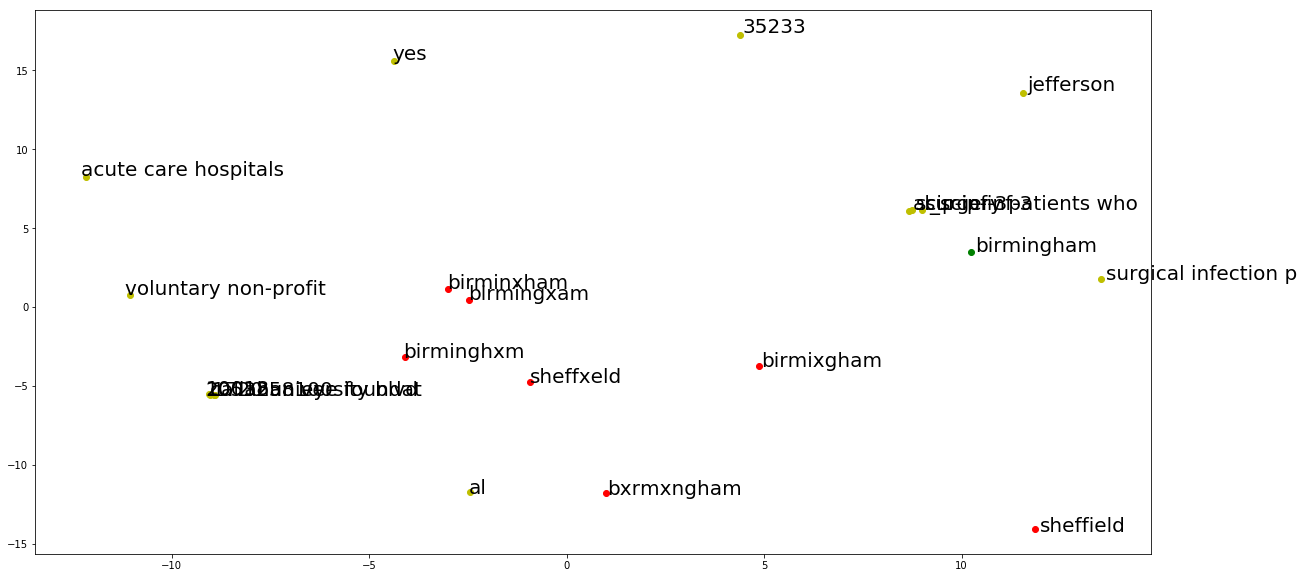

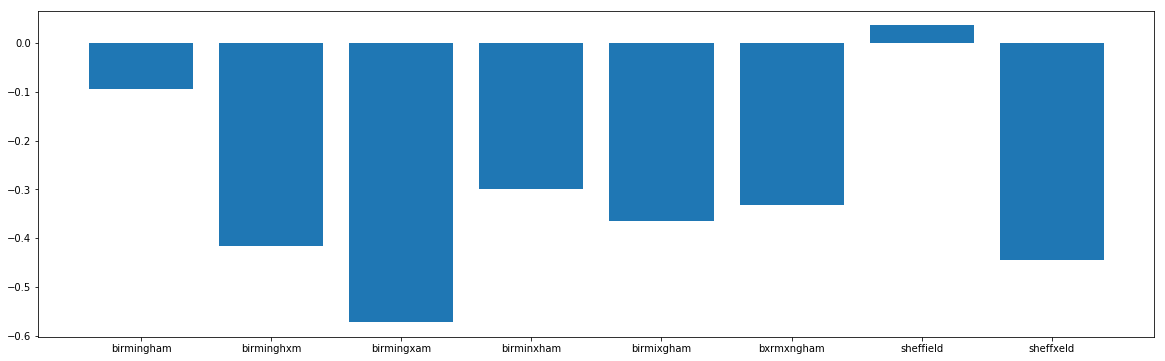

In [125]:
plot_tid(3, 'City')

## Plot similar init values (from in_W)


Expectation: similar values should be close together in in_W to allow "error" init values to be approximated to their good values.

In [75]:
def plot_sim_dom(attr, seed_val):
    sim_vals = list(df_ref.loc[df_ref.correct_val == seed_val, 'init_value'].unique())
        
    plt.figure(figsize=(20,10))
    
    for val in sim_vals:
        x, y = inW_vecs[idxs[attr][val]]
        if val == seed_val:
            plt.plot(x, y, 'go')
        else:
            plt.plot(x, y, 'ro')
        plt.text(x * (1 + 0.01), y * (1 + 0.01) , val[:20], fontsize=20) 
        
        
    # random attr values for comparison
    
    rand_vals = list(filter(lambda val: val not in sim_vals, df_ref.loc[df_ref.attribute == attr, 'correct_val'].unique()))
    rand_vals = np.random.choice(rand_vals, size=max(10, len(rand_vals)))
    for val in rand_vals:
        x, y = inW_vecs[idxs[attr][val]]
        plt.plot(x, y, 'yo')
        plt.text(x * (1 + 0.01), y * (1 + 0.01) , val[:20], fontsize=20) 

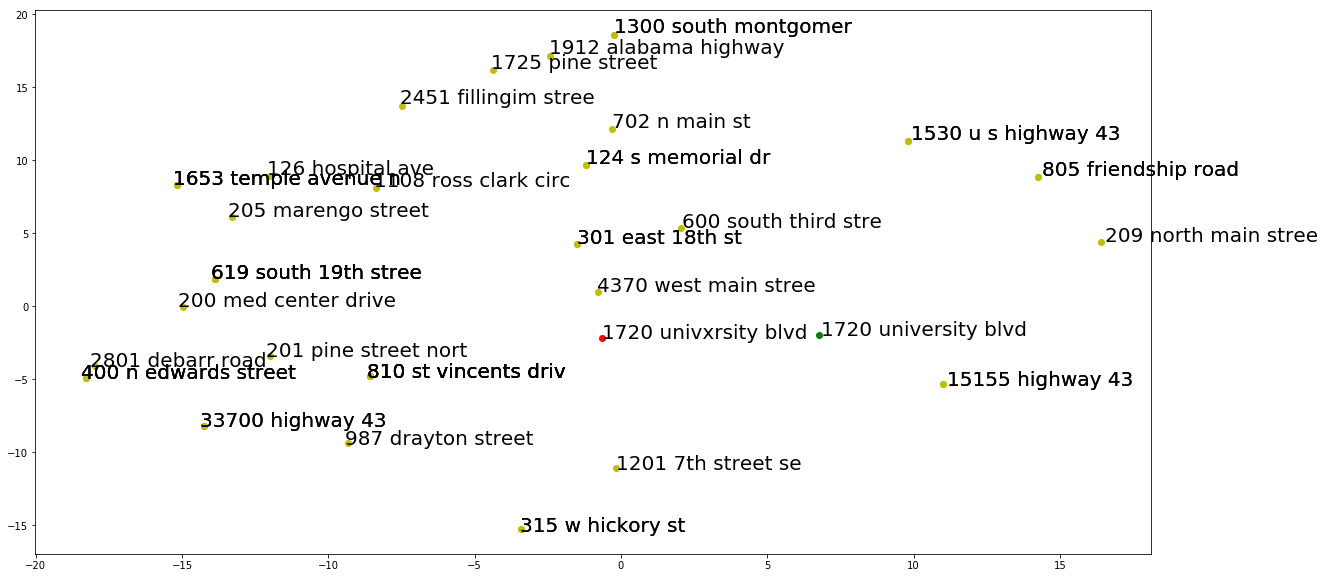

In [80]:
plot_sim_dom('Address1', '1720 university blvd')

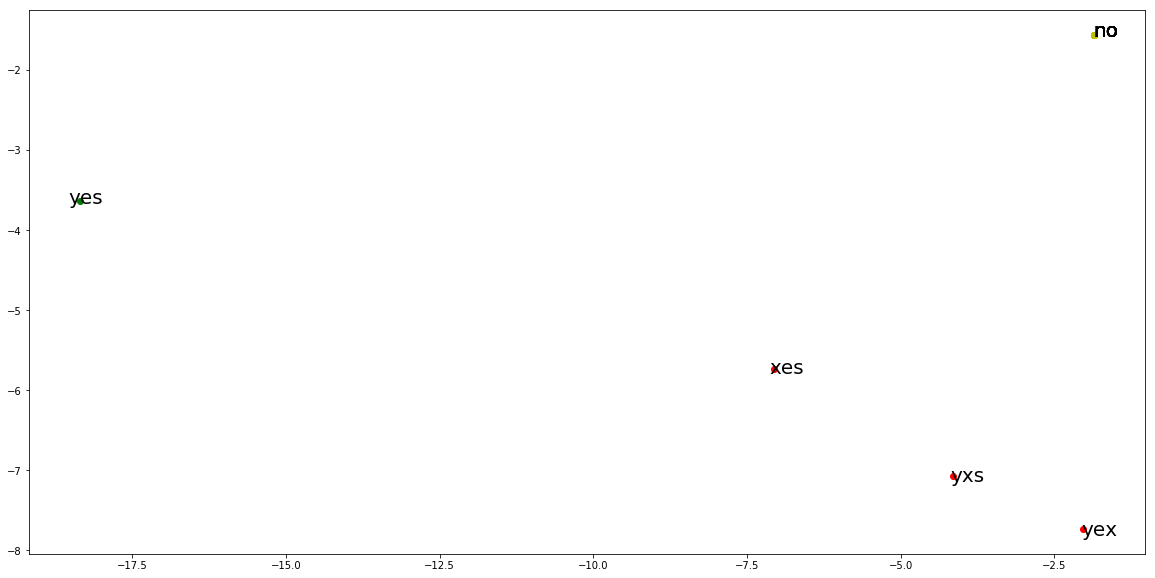

In [81]:
plot_sim_dom('EmergencyService', 'yes')

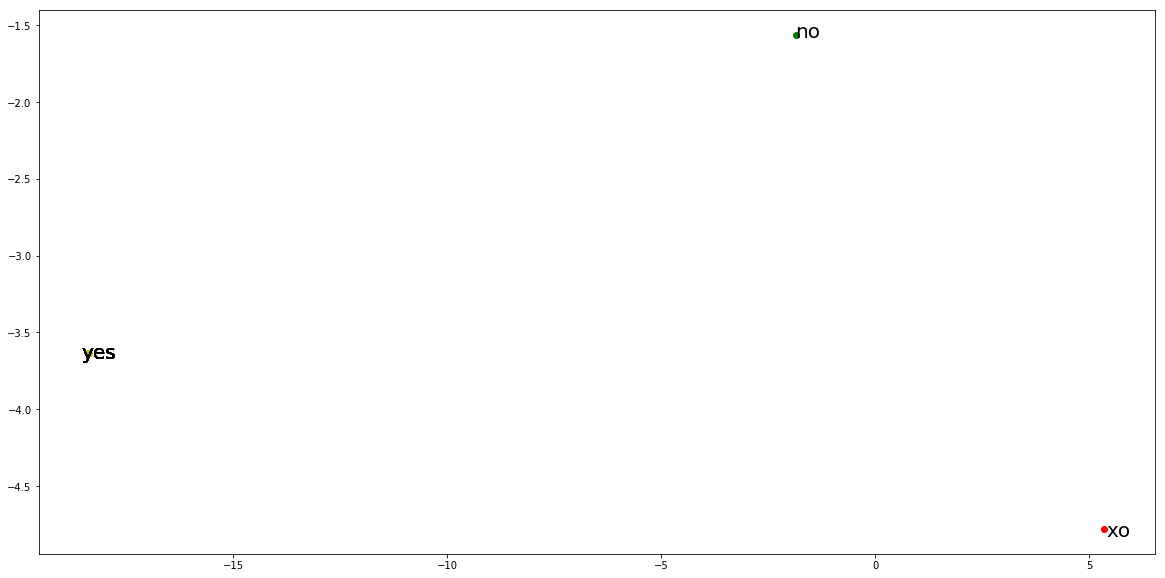

In [82]:
plot_sim_dom('EmergencyService', 'no')

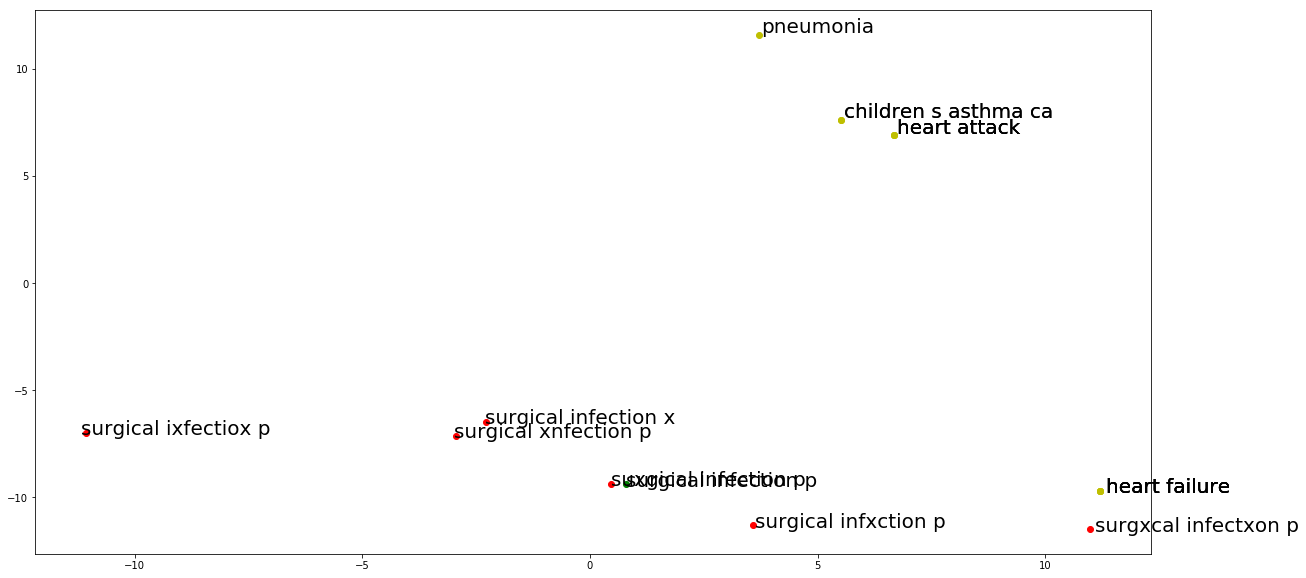

In [83]:
plot_sim_dom('Condition', 'surgical infection prevention')